# Modélisation prédictive des impayés dans les financements leasing

Ce notebook contient l'analyse et la modélisation prédictive des impayés dans les financements leasing à Afriland First Bank.

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')
sns.set_palette('husl')

C:\Users\Nathan\AppData\Local\Temp\ipykernel_25436\282032295.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Chargement et préparation des données

In [2]:
# Chargement des données
base_leasing = pd.read_excel("base_leasing_finale.xlsx")

# Création de l'identifiant unique pour chaque échéance
base_leasing['id_echeance'] = base_leasing['code_client'].astype(str) + '_' + \
                            base_leasing['reference_lettrage'] + '_' + \
                            base_leasing['n_echance'].astype(str)

# Définition de id_echeance comme index
base_leasing.set_index('id_echeance', inplace=True)

# Affichage des informations sur la base de données
print("Informations sur la base de données :")
print(f"Nombre total d'échéances : {len(base_leasing)}")
print(f"Nombre de clients uniques : {base_leasing['code_client'].nunique()}")
print(f"Nombre de contrats uniques : {base_leasing['reference_lettrage'].nunique()}")

# Distribution de la variable cible
print("\nDistribution de la variable statut :")
print(base_leasing['statut'].value_counts(normalize=True))

Informations sur la base de données :
Nombre total d'échéances : 15309
Nombre de clients uniques : 477
Nombre de contrats uniques : 816

Distribution de la variable statut :
statut
paye      0.54027
impaye    0.45973
Name: proportion, dtype: float64


## 2. Prétraitement des variables catégorielles

In [3]:
# Variables catégorielles à dumméiser
categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
                      'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

# Dumméisation des variables catégorielles
base_leasing_dummy = pd.get_dummies(base_leasing, columns=categorical_columns, drop_first=True)

# Affichage des nouvelles colonnes créées par la dumméisation
print("Nouvelles colonnes créées par la dumméisation :")
print([col for col in base_leasing_dummy.columns if col.startswith(tuple(categorical_columns))])

Nouvelles colonnes créées par la dumméisation :
['objet_credit_groupe_BUS', 'objet_credit_groupe_CAMION', 'objet_credit_groupe_ENGIN', 'objet_credit_groupe_MACHINE', 'objet_credit_groupe_REMORQUE', 'objet_credit_groupe_VOITURE', 'type_Société', 'segment_GE', 'segment_INS', 'segment_ME', 'segment_PAR', 'segment_PE', 'segment_TPE', 'profil_activite_Autres', 'profil_activite_Entreprise Privee Individuelle', 'profil_activite_Entreprise incubees', "profil_activite_Organisme de l'Etat", 'profil_activite_Profession Liberale', 'secteur_risque_Activités Financières et Assurance', 'secteur_risque_Commerce', 'secteur_risque_Construction', 'secteur_risque_Energie', 'secteur_risque_Industries', 'secteur_risque_Production Autres Services', 'secteur_risque_Secteur Public', 'secteur_risque_Transports', 'secteur_risque_Télécommunications', 'forme_juridique_EURL', 'forme_juridique_GIE', 'forme_juridique_SA', 'forme_juridique_SARL', 'forme_juridique_SAS', 'forme_juridique_SCI', 'forme_juridique_SP', 'res

## 3. Préparation des features et division des données

In [4]:
# Variables numériques à utiliser
numeric_features = ['echa_impaye_avant', 'montant_credit',
                   'total_echeance', 'capital_rembourse', 'capital_restant', 'nbre_ech',
                   'taux_interet', 'age_credit_jours', 'nb_cpt', 'cum_taux_paiement']

# Création des features en combinant variables numériques et dummifiées
features = numeric_features + [col for col in base_leasing_dummy.columns if col.startswith(tuple(categorical_columns))]

# Création de la variable cible binaire
y = (base_leasing_dummy['statut'] == 'impaye').astype(int)

# Création de la matrice X
X = base_leasing_dummy[features]

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisation des variables numériques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dimensions des ensembles d'entraînement et de test :")
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")

Dimensions des ensembles d'entraînement et de test :
X_train : (12247, 56)
X_test : (3062, 56)


## 4. Définition et évaluation des modèles avec gestion de l'overfitting

In [5]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve


Évaluation du modèle Logistic Regression avec cross-validation...
[[1354  300]
 [ 329 1079]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1654
           1       0.78      0.77      0.77      1408

    accuracy                           0.79      3062
   macro avg       0.79      0.79      0.79      3062
weighted avg       0.79      0.79      0.79      3062



c:\Users\Nathan\anaconda3\envs\appenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Nathan\anaconda3\envs\appenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Évaluation du modèle Decision Tree avec cross-validation...
[[1649    5]
 [  10 1398]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1654
           1       1.00      0.99      0.99      1408

    accuracy                           1.00      3062
   macro avg       1.00      0.99      1.00      3062
weighted avg       1.00      1.00      1.00      3062


Évaluation du modèle Random Forest avec cross-validation...
[[1654    0]
 [  10 1398]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1654
           1       1.00      0.99      1.00      1408

    accuracy                           1.00      3062
   macro avg       1.00      1.00      1.00      3062
weighted avg       1.00      1.00      1.00      3062



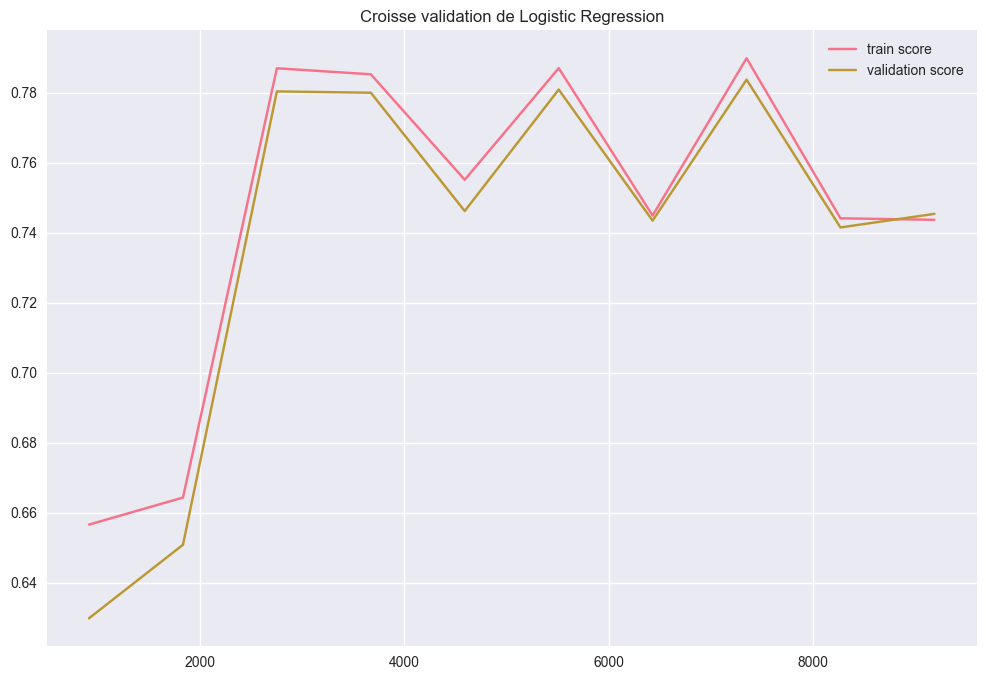

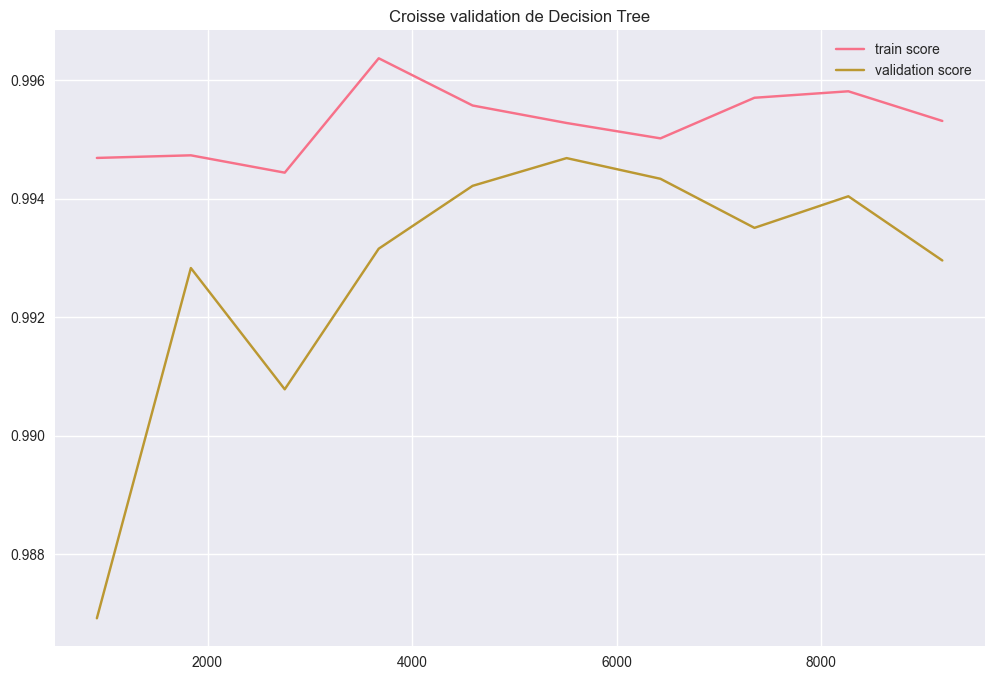

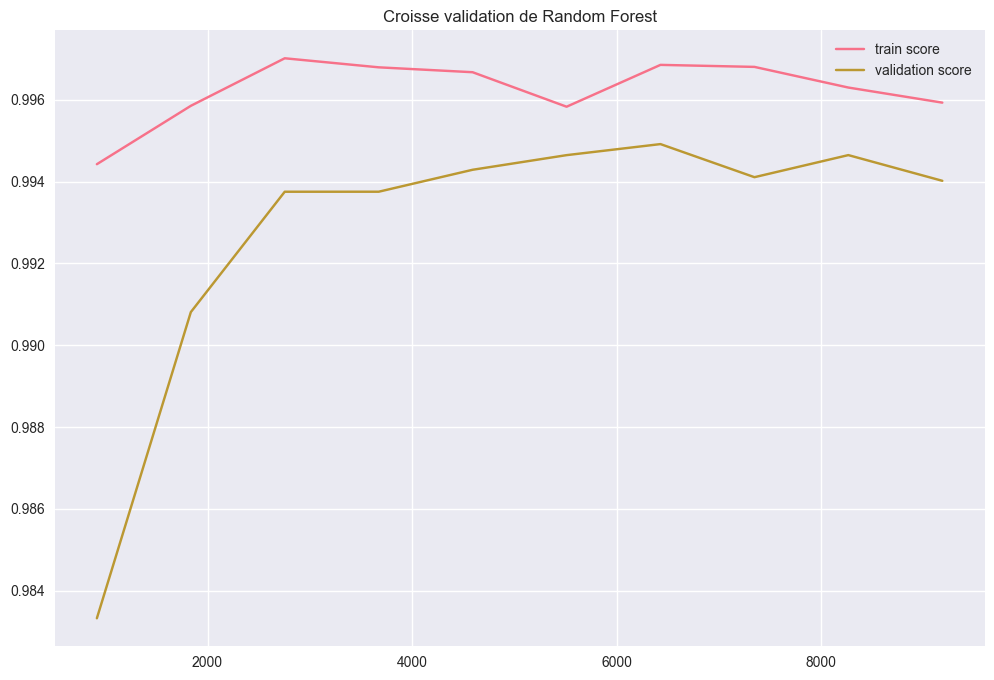

In [6]:
# Création d'un dictionnaire pour stocker les modèles avec leurs paramètres optimisés
models = {
    'Logistic Regression': LogisticRegression(
        C=0.1,  # Paramètre de régularisation (plus petit = plus de régularisation)
        max_iter=1000,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=5,  # Limite la profondeur de l'arbre
        min_samples_split=10,  # Nombre minimum d'échantillons requis pour diviser un nœud
        min_samples_leaf=5,  # Nombre minimum d'échantillons requis dans un nœud feuille
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',  # Nombre de features à considérer pour chaque split
        random_state=42
     )#,
    # 'XGBoost': xgb.XGBClassifier(
    #     n_estimators=100,
    #     max_depth=5,
    #     learning_rate=0.1,
    #     subsample=0.8,  # Utilise 80% des données pour chaque arbre
    #     colsample_bytree=0.8,  # Utilise 80% des features pour chaque arbre
    #     random_state=42
    # ),
    # 'LightGBM': lgb.LGBMClassifier(
    #     n_estimators=100,
    #     max_depth=5,
    #     learning_rate=0.1,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42
    # )
}

# def evaluation(model):
    
#     model.fit(X_train, y_train)
#     ypred = model.predict(X_test)
    
#     print(confusion_matrix(y_test, ypred))
#     print(classification_report(y_test, ypred))
    
#     N, train_score, val_score = learning_curve(model, X_train, y_train,
#                                               cv=4, scoring='f1',
#                                                train_sizes=np.linspace(0.1, 1, 10))
    
    
#     plt.figure(figsize=(12, 8))
#     plt.plot(N, train_score.mean(axis=1), label='train score')
#     plt.plot(N, val_score.mean(axis=1), label='validation score')
#     plt.legend()

# Fonction pour évaluer les modèles avec cross-validation 
#, X, y, cv=5
def evaluate_models_with_cv(models):
    results = {}
    for name, model in models.items():
        print(f"\nÉvaluation du modèle {name} avec cross-validation...")
        
        # # Cross-validation
        # cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
        # print(f"Scores de cross-validation (AUC-ROC): {cv_scores}")
        # print(f"Moyenne des scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        model.fit(X_train, y_train)
        ypred = model.predict(X_test)
        
        print(confusion_matrix(y_test, ypred))
        print(classification_report(y_test, ypred))
        
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                cv=4, scoring='f1',
                                                train_sizes=np.linspace(0.1, 1, 10))
        
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Croisse validation de {name}")
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.legend()

        # Entraînement sur l'ensemble complet
        #model.fit(X, y)
        
        # # Feature importance pour les modèles qui le supportent
        # if hasattr(model, 'feature_importances_'):
        #     feature_importance = pd.DataFrame({
        #         'feature': features,
        #         'importance': model.feature_importances_
        #     })
        #     feature_importance = feature_importance.sort_values('importance', ascending=False)
        #     print("\nTop 5 des features les plus importantes :")
        #     print(feature_importance.head(5))
        
        # results[name] = {
        #     'cv_scores': cv_scores,
        #     'cv_mean': cv_scores.mean(),
        #     'cv_std': cv_scores.std()
        # }
    
    return results

# Évaluation des modèles avec cross-validation
cv_results = evaluate_models_with_cv(models)

In [8]:
# for name, model in models.items():
#     print(name)
#     evaluation(model)

****
> `` Notre premier axe factoriel explique à lui tout seul près de 99.46% de l'information totale. le deuxième axe explique 0.51% et le troisième axe 0.02%. cette difference peut etre due au déséquilibre existant entre les differentes classes de notre variables target "attrition_risk" ``


Ainsi, le facteur 1 a plus de pouvoir discriminant que les deux autres facteurs
****

1. Variables liées au comportement de paiement
Ce sont généralement les plus prédictives :

retard_jours : nombre de jours de retard sur l’échéance actuelle.

taux_paiement : proportion du montant payé sur ce qui est dû.

ech_impaye_avant : nombre ou proportion d’échéances impayées précédentes (excellent indicateur).

prop_ech : peut représenter la position de l’échéance dans le calendrier du crédit (e.g., 3e/12).

✅ Ces variables mesurent le comportement passé du client, très utile pour le scoring.

💰 2. Caractéristiques du contrat de crédit
montant_credit : montant total octroyé.

total_echeance : montant dû à cette échéance.

capital_rembourse / capital_restant : indicateurs d’avancement du remboursement.

nbre_ech : nombre total d’échéances.

taux_interet : coût du crédit, possible effet sur le taux de défaut.

age_credit_jours : ancienneté du contrat.

✅ Ces variables capturent la structure du crédit et sa maturité, qui peuvent impacter le risque.

🧑‍💼 Caractéristiques du client
segment : TPE / PME / Grandes entreprises.

forme_juridique : SARL, SA, etc.

profil_activite / secteur_risque : secteur économique (certains plus risqués).

age_entreprise / date_creation : entreprise jeune = plus risquée en général.

nb_cpt : nombre de comptes du client (peut refléter la relation avec la banque).

reseau : réseau d’affectation (zone géographique ou réseau commercial).

✅ Ces variables permettent d’évaluer la solidité ou la maturité de l’entreprise.



In [2]:
# with pm.Model() as poisson_model:
#     lambda_ = pm.Exponential("lambda", 1.0)  # prior sur le taux
#     obs = pm.Poisson("obs", mu=lambda_, observed=[3, 4, 2, 6, 5])
#     trace = pm.sample()


In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# # Exemple avec tes montants payés
# montants = np.array([
#     14409452.32, 14056889.11, 13701192.37, 13342334.26,
#     12980286.66, 12615021.24, 12246509.4, 11874722.28,
#     11499630.76, 11121205.49, 10739416.84, 10354234.9,
#     9965629.52, 33463048.95, 32097250.98, 30720123.26,
#     29331571.81, 27931501.88, 26519817.9
# ])

# plt.hist(montants, bins=10, density=True, alpha=0.6, label="Données")

# # Ajuster une log-normale
# shape, loc, scale = stats.lognorm.fit(montants, floc=0)
# x = np.linspace(min(montants), max(montants), 100)
# plt.plot(x, stats.lognorm.pdf(x, shape, loc, scale), label="Log-normale", color='red')

# # Ajuster une gamma
# a, loc, scale = stats.gamma.fit(montants, floc=0)
# plt.plot(x, stats.gamma.pdf(x, a, loc, scale), label="Gamma", color='green')

# plt.legend()
# plt.title("Ajustement de distributions sur les montants payés")
# plt.show()

## 5. Optimisation des hyperparamètres avec GridSearchCV

In [ ]:
# Exemple pour Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print("Optimisation des hyperparamètres pour Random Forest...")
grid_search_rf.fit(X_train_scaled, y_train)

print("\nMeilleurs paramètres :")
print(grid_search_rf.best_params_)
print("\nMeilleur score :")
print(grid_search_rf.best_score_)

## 6. Feature Selection

In [ ]:
# Feature selection avec Random Forest
selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    max_features=20  # Sélectionne les 20 features les plus importantes
)

# Application de la sélection de features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Récupération des features sélectionnées
selected_features = [features[i] for i in range(len(features)) if selector.get_support()[i]]
print("\nFeatures sélectionnées :")
print(selected_features)

# Entraînement du modèle final avec les features sélectionnées
final_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
final_model.fit(X_train_selected, y_train)

# Évaluation du modèle final
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]

print("\nRésultats du modèle final :")
print(f"Accuracy: {(y_pred == y_test).mean():.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Modèle Final')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() 